# 12년치 데이터 역방향 분석(최근 트랜드 반영)

In [ ]:
!pip install tf-nightly

     |████████████████████████████████| 395.8MB 44kB/s 
     |████████████████████████████████| 14.5MB 252kB/s 
     |████████████████████████████████| 471kB 49.8MB/s 
     |████████████████████████████████| 10.6MB 42.0MB/s 
     |████████████████████████████████| 3.8MB 50.3MB/s 
     |████████████████████████████████| 1.3MB 42.3MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4
  Found existing installation: grpcio 1.33.2
    Uninstalling grpcio-1.33

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


train data % : 1.25 test data % : 22.18
Epoch 1/500
32/32 [==============================] - 10s 151ms/step - loss: 0.4193 - accuracy: 0.8462 - val_loss: 0.6836 - val_accuracy: 0.5107

Epoch 00001: loss improved from inf to 0.25026, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5
Epoch 2/500
32/32 [==============================] - 4s 127ms/step - loss: 0.0717 - accuracy: 0.9876 - val_loss: 0.6957 - val_accuracy: 0.5118

Epoch 00002: loss improved from 0.25026 to 0.07440, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5
Epoch 3/500
32/32 [==============================] - 4s 125ms/step - loss: 0.0818 - accuracy: 0.9865 - val_loss: 0.7031 - val_accuracy: 0.5107

Epoch 00003: loss improved from 0.07440 to 0.07343, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5
Epoch 4/500
32/32 [==============================] - 4s 125ms/step - loss: 0.0706 - accuracy: 0.9866 - val_loss: 0.6564 - val_accuracy: 0.527

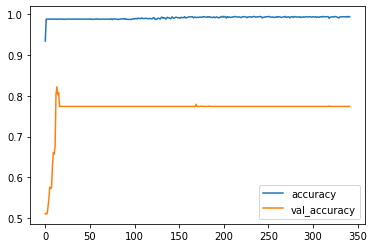

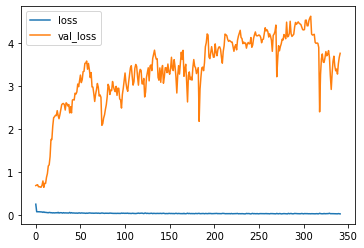

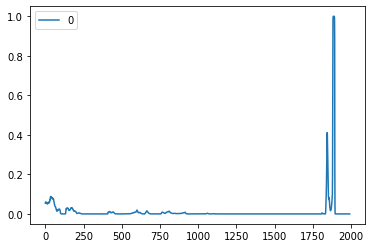

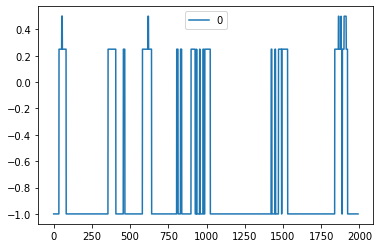

In [ ]:
# 데이터 불러오기
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

# 데이터 변수명 지정
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
# 불러온 데이터를 날짜를 기준으로 뒤집고, 저장
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

# 주식 데이터 및 금 데이터 로짓
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

# 조정종가와 종가의 차이를 기반으로 기업의 재무적 이벤트를 반영
df['gap'] = df['adj']/df['close'] 

# 특정일의 가격이 아닌 5일 종가를 통해 타겟 구간화
df['mov5'] = df['adj'].rolling(5).mean()

# 1년 이내 11개 수익 구간을 지정
df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

# 해당 수익 구간이 올바른 위치에 있도록 조정
df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

# 현실적인 수준인 상위 3, 4, 5위 수익율의 평균을 목표로 삼아 지정
df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

# 수익율 등을 지정하는 과정에서 생긴 na열 제거
df = df.dropna(axis=0)

df['return'].describe()

# 산출한 수익율들을 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return']  <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return']  <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return']  <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

# 분석의 목표인 최근 데이터가 학습 데이터에 들어있으므로, loss값을 기준으로 monitoring
from tensorflow.keras.callbacks import ModelCheckpoint
modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5"
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'loss', verbose = 1, save_best_only = True)

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 100)

# 독립변수와 종속변수 지정
input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

# 한 번에 분석할 데이터의 시계열 등을 지정
T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest / Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

# EnSemble : LSTM + SimpleRNN + GRU

i = Input(shape=(T,D))

# 과대적합과 모델이 빠르게 식상해지는 것을 방지하기 위해 dropout option 추가
lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2)
left_input = Input(shape= (T,D))
left_output = lstm(left_input)

rnn = SimpleRNN(128, dropout = 0.2, recurrent_dropout = 0.2)
middle_input = Input(shape= (T,D))
middle_output = rnn(middle_input)

gru = GRU(128,  dropout=0.2, recurrent_dropout=0.2)
right_input = Input(shape= (T,D))
right_output = gru(right_input)

# merge
merged = tf.keras.layers.concatenate([left_output,middle_output, right_output], axis = -1)
merged = Dropout(rate=0.7)(merged)
merged = Dense(256, activation='relu')(merged)
merged = Dropout(rate=0.7)(merged)
merged = Dense(5, LeakyReLU(alpha=0.1))(merged)
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid')(merged)

model = Model([left_input,middle_input, right_input], predictions)

# 대용량 데이터이기 때문에 학습율을 0.0005로 낮게 잡음
# 데이터의 속성을 제일 잘 반영할 수 있는 Nadam을 optimizer로 선택
model.compile(
    loss = 'binary_crossentropy',
    sample_weight_mode = 'temporal',
    optimizer = Nadam(lr = 0.0005),
    metrics = ['accuracy'],
)

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

# 모델의 정확도와 로스 측정
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return']  <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return']  <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return']  <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


train data % : 0.2 test data % : 8.72
Epoch 1/500
32/32 [==============================] - 7s 134ms/step - loss: 0.0328 - accuracy: 0.9970 - val_loss: 1.1696 - val_accuracy: 0.9110

Epoch 00001: loss did not improve from 0.02442
Epoch 2/500
32/32 [==============================] - 4s 117ms/step - loss: 0.0190 - accuracy: 0.9980 - val_loss: 1.0307 - val_accuracy: 0.9110

Epoch 00002: loss improved from 0.02442 to 0.01895, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5
Epoch 3/500
32/32 [==============================] - 4s 111ms/step - loss: 0.0142 - accuracy: 0.9980 - val_loss: 0.9691 - val_accuracy: 0.9110

Epoch 00003: loss improved from 0.01895 to 0.01421, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5
Epoch 4/500
32/32 [==============================] - 4s 112ms/step - loss: 0.0178 - accuracy: 0.9980 - val_loss: 0.9285 - val_accuracy: 0.9110

Epoch 00004: loss did not improve from 0.01421
Epoch 5/500
32/32 [=============

train data % : 76.05 test data % : 64.05999999999999
Epoch 1/5000
25/25 [==============================] - 8s 168ms/step - loss: 0.5750 - accuracy: 0.7335 - val_loss: 0.5957 - val_accuracy: 0.6567

Epoch 00001: val_loss did not improve from 0.16313
Epoch 2/5000
25/25 [==============================] - 3s 134ms/step - loss: 0.4720 - accuracy: 0.7747 - val_loss: 0.5516 - val_accuracy: 0.7711

Epoch 00002: val_loss did not improve from 0.16313
Epoch 3/5000
25/25 [==============================] - 3s 137ms/step - loss: 0.4209 - accuracy: 0.8154 - val_loss: 0.5741 - val_accuracy: 0.6645

Epoch 00003: val_loss did not improve from 0.16313
Epoch 4/5000
25/25 [==============================] - 3s 137ms/step - loss: 0.4075 - accuracy: 0.8299 - val_loss: 0.5793 - val_accuracy: 0.6593

Epoch 00004: val_loss did not improve from 0.16313
Epoch 5/5000
25/25 [==============================] - 3s 136ms/step - loss: 0.3775 - accuracy: 0.8350 - val_loss: 0.6591 - val_accuracy: 0.6281

Epoch 00005: val_l

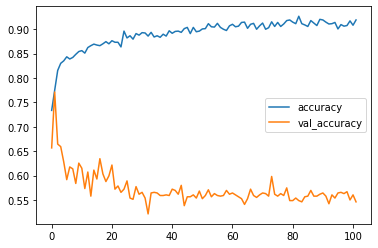

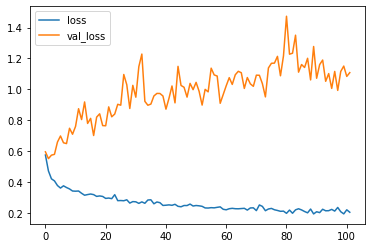

예측 결과 : 205.38855
실제 결과: 505.0
학습된 모델은 미래를 59.330000000000005 %  비관적으로 전망하고 있습니다.


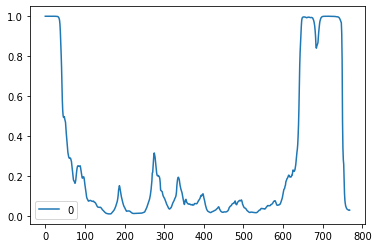

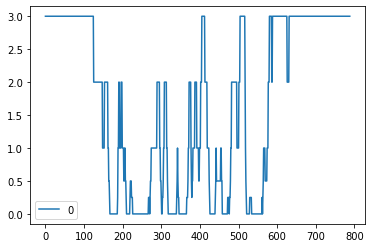

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return']  <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return']  <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return']  <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


train data % : 76.6 test data % : 89.64
Epoch 1/5000
32/32 [==============================] - 9s 157ms/step - loss: 0.3827 - accuracy: 0.8355 - val_loss: 1.1015 - val_accuracy: 0.3262

Epoch 00001: val_loss did not improve from 0.16313
Epoch 2/5000
32/32 [==============================] - 5s 146ms/step - loss: 0.2982 - accuracy: 0.8651 - val_loss: 1.1920 - val_accuracy: 0.2822

Epoch 00002: val_loss did not improve from 0.16313
Epoch 3/5000
32/32 [==============================] - 4s 136ms/step - loss: 0.2941 - accuracy: 0.8631 - val_loss: 1.2461 - val_accuracy: 0.2751

Epoch 00003: val_loss did not improve from 0.16313
Epoch 4/5000
32/32 [==============================] - 4s 135ms/step - loss: 0.2733 - accuracy: 0.8716 - val_loss: 1.1807 - val_accuracy: 0.3160

Epoch 00004: val_loss did not improve from 0.16313
Epoch 5/5000
32/32 [==============================] - 4s 137ms/step - loss: 0.2415 - accuracy: 0.8932 - val_loss: 1.3705 - val_accuracy: 0.3456

Epoch 00005: val_loss did not i

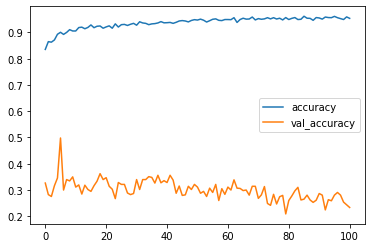

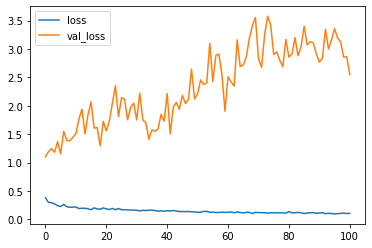

예측 결과 : 164.22995
실제 결과: 894.0
학습된 모델은 미래를 81.63 %  비관적으로 전망하고 있습니다.


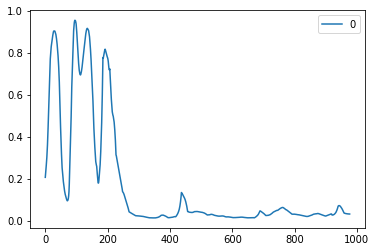

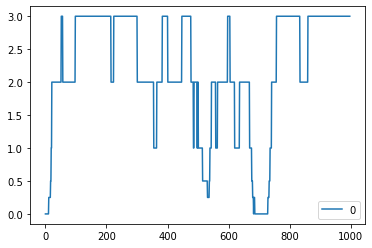

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/AAPL.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return']  <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return']  <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return']  <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")

# 모델 객체 만들고 훈련

r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


train data % : 68.38 test data % : 81.92
Epoch 1/5000
32/32 [==============================] - 9s 155ms/step - loss: 0.5362 - accuracy: 0.7668 - val_loss: 0.8710 - val_accuracy: 0.1646

Epoch 00001: val_loss did not improve from 0.16313
Epoch 2/5000
32/32 [==============================] - 4s 135ms/step - loss: 0.4318 - accuracy: 0.8084 - val_loss: 1.1687 - val_accuracy: 0.1646

Epoch 00002: val_loss did not improve from 0.16313
Epoch 3/5000
32/32 [==============================] - 4s 136ms/step - loss: 0.4186 - accuracy: 0.8180 - val_loss: 1.1240 - val_accuracy: 0.2403

Epoch 00003: val_loss did not improve from 0.16313
Epoch 4/5000
32/32 [==============================] - 4s 134ms/step - loss: 0.4220 - accuracy: 0.8195 - val_loss: 1.4335 - val_accuracy: 0.1646

Epoch 00004: val_loss did not improve from 0.16313
Epoch 5/5000
32/32 [==============================] - 4s 133ms/step - loss: 0.3953 - accuracy: 0.8335 - val_loss: 1.2119 - val_accuracy: 0.2474

Epoch 00005: val_loss did not 

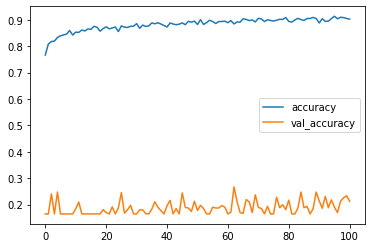

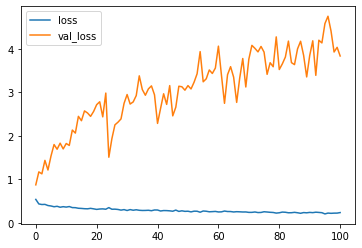

예측 결과 : 58.351456
실제 결과: 817.0
학습된 모델은 미래를 92.86 %  비관적으로 전망하고 있습니다.


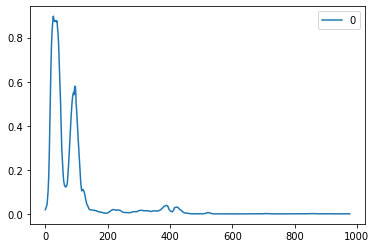

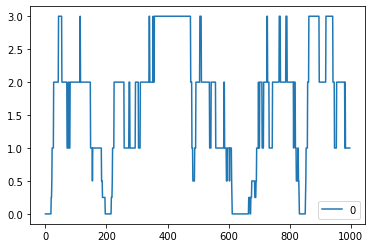

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/INTC.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return']  <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return']  <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return']  <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


train data % : 54.7 test data % : 88.24
Epoch 1/5000
32/32 [==============================] - 9s 159ms/step - loss: 0.6892 - accuracy: 0.6720 - val_loss: 1.2225 - val_accuracy: 0.2055

Epoch 00001: val_loss did not improve from 0.16313
Epoch 2/5000
32/32 [==============================] - 4s 135ms/step - loss: 0.5548 - accuracy: 0.7307 - val_loss: 1.3928 - val_accuracy: 0.1636

Epoch 00002: val_loss did not improve from 0.16313
Epoch 3/5000
32/32 [==============================] - 4s 136ms/step - loss: 0.5249 - accuracy: 0.7382 - val_loss: 1.4112 - val_accuracy: 0.1810

Epoch 00003: val_loss did not improve from 0.16313
Epoch 4/5000
32/32 [==============================] - 4s 134ms/step - loss: 0.4830 - accuracy: 0.7693 - val_loss: 1.9195 - val_accuracy: 0.1544

Epoch 00004: val_loss did not improve from 0.16313
Epoch 5/5000
32/32 [==============================] - 4s 138ms/step - loss: 0.4681 - accuracy: 0.7753 - val_loss: 1.7919 - val_accuracy: 0.1922

Epoch 00005: val_loss did not i

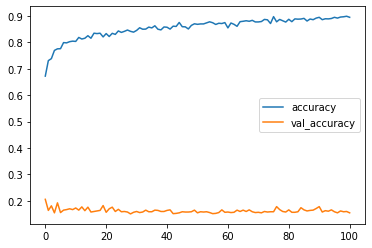

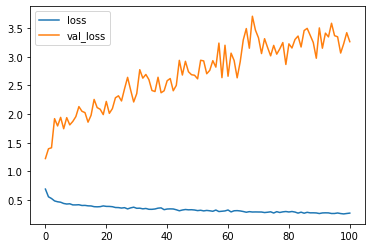

예측 결과 : 78.497086
실제 결과: 880.0
학습된 모델은 미래를 91.08000000000001 %  비관적으로 전망하고 있습니다.


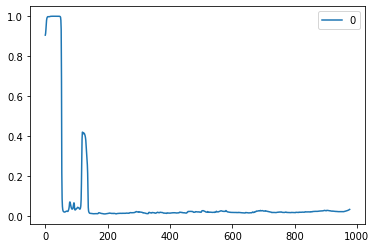

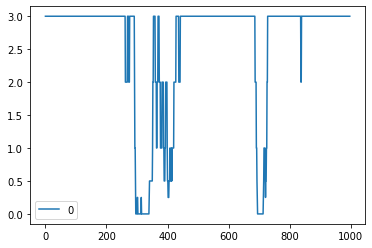

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return']  <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return']  <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return']  <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


train data % : 82.3 test data % : 59.519999999999996
Epoch 1/5000
32/32 [==============================] - 9s 157ms/step - loss: 0.5391 - accuracy: 0.8128 - val_loss: 0.7178 - val_accuracy: 0.6070

Epoch 00001: val_loss did not improve from 0.16313
Epoch 2/5000
32/32 [==============================] - 4s 132ms/step - loss: 0.4375 - accuracy: 0.8213 - val_loss: 0.6722 - val_accuracy: 0.6070

Epoch 00002: val_loss did not improve from 0.16313
Epoch 3/5000
32/32 [==============================] - 4s 133ms/step - loss: 0.3983 - accuracy: 0.8248 - val_loss: 0.6386 - val_accuracy: 0.6387

Epoch 00003: val_loss did not improve from 0.16313
Epoch 4/5000
32/32 [==============================] - 4s 141ms/step - loss: 0.3690 - accuracy: 0.8348 - val_loss: 0.6170 - val_accuracy: 0.6397

Epoch 00004: val_loss did not improve from 0.16313
Epoch 5/5000
32/32 [==============================] - 4s 138ms/step - loss: 0.3423 - accuracy: 0.8529 - val_loss: 0.6041 - val_accuracy: 0.6592

Epoch 00005: val_l

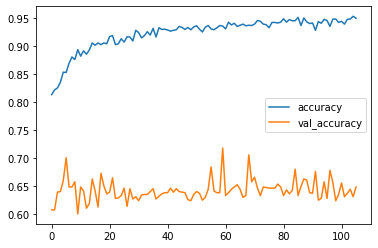

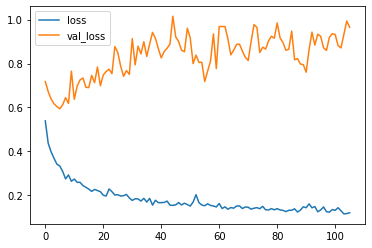

예측 결과 : 676.6024
실제 결과: 593.0
학습된 모델은 미래를 14.099999999999998 % 낙관적으로 전망하고 있습니다.


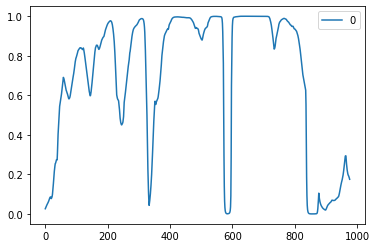

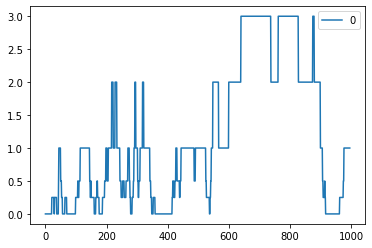

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df.dropna(axis=0)

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return']  <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return']  <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return']  <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train, X_train], 
          Y_train,
          batch_size = 64,
          epochs = 500,
          validation_data = ([X_test, X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-240)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-240)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-240)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-240)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-240)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-240)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-240)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-240)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-240)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-240)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df = df[['date','open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap','return']]

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return']  <= -0.1 : result = -1              # 확정 손실 구간
  elif -0.3 < row['return']  <= -0.2 : result = -2              # 높은 손실 구간
  elif row['return']  <= -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df2 = df.dropna(axis=0)

input_data = df2[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return']
target2 = df['return02']
date = df['date']

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]


from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01.hdf5")
model1_pred = model1.predict([X_2020,X_2020,X_2020])
print(len(input_data))

###
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")
df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-240)- df['mov5'].shift(-239))/df['mov5'].shift(-1)
df['1w'] = (df['mov5'].shift(-240)- df['mov5'].shift(-235))/df['mov5'].shift(-5)
df['2w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-230))/df['mov5'].shift(-10)
df['4w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-220))/df['mov5'].shift(-20)
df['6w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-210))/df['mov5'].shift(-30)
df['8w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-200))/df['mov5'].shift(-40)
df['10w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-190))/df['mov5'].shift(-50)
df['12w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-180))/df['mov5'].shift(-60)
df['18w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-150))/df['mov5'].shift(-90)
df['24w'] = (df['mov5'].shift(-240) - df['mov5'].shift(-120))/df['mov5'].shift(-120)
df['48w'] = (df['mov5'].shift(-240) - df['mov5'])/df['mov5'].shift(-240)

df['1d'] = df['1d'].shift(240)
df['1w'] =df['1w'].shift(240)
df['2w'] = df['2w'].shift(240)
df['4w'] = df['4w'].shift(240)
df['6w'] = df['6w'].shift(240)
df['8w'] = df['8w'].shift(240)
df['10w'] = df['10w'].shift(240)
df['12w'] = df['12w'].shift(240)
df['18w'] = df['18w'].shift(240)
df['24w'] = df['24w'].shift(240)
df['48w'] = df['48w'].shift(240)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,8] + np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6])/3

df2 = df2

input_data = df2[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return']
target2 = df['return02']
date = df['date']

T = 20
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_01r.hdf5")
model2_pred = model2.predict([X_2020,X_2020])
print(len(model2_pred))

###

pred_01 = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))

len_1 = len(model1_pred)-len(model2_pred)
len_2 = len(model1_pred) - len(model3_pred)

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  
  if i <  len_1 :
    pred_02[i] = 0
  else : 
    pred_02[i] = model2_pred[i-len_1]

df4 = pd.DataFrame()
df4['date'] = pd.Series(date)
df4['pred01'] = pd.Series(pred_01)
df4['pred01r'] = pd.Series(pred_02)
df4['result'] = pd.Series(target)
df4['result02'] = pd.Series(target2)

df4 = df4.dropna(axis=0)
df4.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df4.to_csv("/content/gdrive/My Drive/dataset_AMZN.csv", index=False)
df = pd.read_csv("/content/gdrive/My Drive/dataset_AMZN.csv")
df.info()

plt.figure(figsize=(12,8))
plt.plot(df['pred01'],label ='pred01' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred01r'],label ='pred01r' , color = 'cyan', linestyle = '-.', linewidth = 3)


plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.axvline(758, color = 'darkgrey', linestyle='--', linewidth = 3)
plt.axvline(1512, color = 'darkgrey', linestyle='--', linewidth = 3)
plt.axvline(2268, color = 'darkgrey', linestyle='--', linewidth = 3)

plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['result'],label ='result1', color = 'lightcoral',linestyle = '-' , linewidth = 3)
plt.plot(df['result02']/3,label ='result2', color='lightgreen',linestyle = '-' ,linewidth = 3)

plt.axhline( 0.05 , linestyle = ':', color = 'darkorange',linewidth = 5)
plt.axvline(758, color = 'darkgrey', linestyle='--', linewidth = 3)
plt.axvline(1512, color = 'darkgrey', linestyle='--', linewidth = 3)
plt.axvline(2268, color = 'darkgrey', linestyle='--', linewidth = 3)

plt.legend()
plt.show()

NameError: ignored